# Ridge, LASSO, Root-LASSO Regression

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline

## Simulating the AR model
simulate 2nd order AR model: <latex>$y_{k} = a_1y_{k-1}+a_2y_{k-2}+w_{k}$

In [2]:
def systemSimulation(N,a1,a2,noisePwr,signalPwr):
    '''
    @N: int, length of the sequence
    @a1: float, param 1
    @a2: float, param 2
    @noisePwr: float, power of noise
    w: AWGN noise
    '''
    y = np.zeros(N)
    y[0:2] = np.array([5,10])
    for i in range(N-2):
        y[i+2] = a1*y[i+1]+a2*y[i]+np.random.randn()*np.sqrt(noisePwr)
    return y

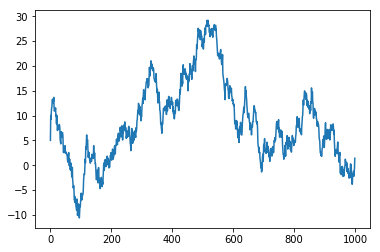

In [3]:
y = systemSimulation(1000,a1=0.9,a2=0.1, noisePwr=1,signalPwr=100)
plt.plot(y)

## Classical Least Square Regression

In [4]:
def LeastSquareRegression(y):
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    estimatedParam = np.linalg.inv(phi@phi.T)@phi@y[2:]
    return estimatedParam

In [5]:
LSEstimation = LeastSquareRegression(y)
print(LSEstimation)

[ 0.84786256  0.14840753]


## Ridge Regression

In [6]:
def RidgeRegression(y,lambdaParam):
    '''
    @lambdaParam: float, parameter for Ridge penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    estimatedParam = np.linalg.inv(phi@phi.T+lambdaParam*np.eye(2))@phi@y[2:]
    return estimatedParam

In [15]:
for lambdaParam in range(10):
    RidgeEstimation = RidgeRegression(y,lambdaParam*100+1)
    print(RidgeEstimation)

[ 0.84724826  0.14901824]
[ 0.79503819  0.20086986]
[ 0.75632548  0.23922555]
[ 0.72646137  0.26873368]
[ 0.70271208  0.29212777]
[ 0.68336484  0.31112045]
[ 0.66729193  0.32683932]
[ 0.65372054  0.34005715]
[ 0.64210333  0.35132122]
[ 0.63204179  0.36103002]


## LASSO Regression

In [16]:
def LassoRegression(y,lambdaParam):
    '''
    @lambdaParam: float, parameter for LASSO penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    LassoEstimation = Variable(2)
    objective = Minimize(sum_squares(y[2:] - phi.T@LassoEstimation)+lambdaParam*pnorm(LassoEstimation,1))
    prob = Problem(objective)
    result = prob.solve()
    return LassoEstimation.value

In [14]:
for lambdaParam in range(10):
    LassoEstimation = LassoRegression(y,lambdaParam*100+1)
    print(LassoEstimation)

[[ 0.84786074]
 [ 0.1484058 ]]
[[ 0.84767924]
 [ 0.14823195]]
[[ 0.84749772]
 [ 0.14805811]]
[[ 0.84731623]
 [ 0.14788425]]
[[ 0.8471348 ]
 [ 0.14771032]]
[[ 0.84695316]
 [ 0.1475366 ]]
[[ 0.84677171]
 [ 0.1473627 ]]
[[ 0.84659014]
 [ 0.14718892]]
[[ 0.84640869]
 [ 0.14701501]]
[[ 0.84622712]
 [ 0.14684123]]


## Square Root LASSO Regression

In [10]:
def RootLassoRegression(y,muParam):
    '''
    @muParam: float, parameter for Square Root LASSO penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    n = np.sqrt(len(y))
    RootLassoEstimation = Variable(2)
    objective = Minimize(n*sum_squares(y[2:] - phi.T@RootLassoEstimation)+muParam*pnorm(RootLassoEstimation,1))
    prob = Problem(objective)
    result = prob.solve(solver='CVXOPT')
    return RootLassoEstimation.value

In [13]:
for muParam in range(10):
    RootLassoEstimation = RootLassoRegression(y,muParam*100+1)
    print(RootLassoEstimation)

[[ 0.84784788]
 [ 0.14839314]]
[[ 0.84636239]
 [ 0.14697074]]
[[ 0.84487719]
 [ 0.14554807]]
[[ 0.84339175]
 [ 0.14412564]]
[[ 0.84190644]
 [ 0.14270307]]
[[ 0.84042112]
 [ 0.14128051]]
[[ 0.83893581]
 [ 0.13985796]]
[[ 0.83745049]
 [ 0.1384354 ]]
[[ 0.83596518]
 [ 0.13701283]]
[[ 0.83447983]
 [ 0.13559031]]
